# Variational Autoencoder 

## Autoencoder


We are encoding the input data to a smaller space and then decoding it to get the original data back

Do that till the reconstruction error is minimal and the latent vector which remains is the low dimensional representation 

Even if the input image is a noisy image, we can trick the model (deocder) into reconstructing a cleaner image

The encoding and decoding phase can be anything from regular Conv2D to LSTMs

In Autoencoder, the decoder part is generative as long as we give latent vectors

but VAE or AE **IS NOT** GAN 


### Applications:
1. By changing the latent vector slightly we can add smile to mona lisa!
2. Sending a large file?
3. Noise Reduction 
4. Domain Adaptation
5. Image Colorization 
6. Anomaly Detection, large reconstruction error for anomaly data

## Variational Autoencoder
Variational part of Autoencoder: 
Latent Distributions are learnt, what if we know the sapce which gives a particularly class?
What if we constriant latent vector values to a specific continuous region?

Instead of mapping to a fixed latent vector, what if map it to a distribution ? using mean and standard deviation 
quantify distance between the learnt distribution to one of the known distrubtion (standard normal distribution) using KL Divergence

in Autoencoder we are mapping to a vector, VAE - map to a distribution

during backpropagation,

z = mu + sigma * epsilon 

mu and sigma are learned during back propagation

epsilon is standard normal distribution, fixed space where we randomaly sample vectors, not learned during back prop


## VAE for MNIST dataset

### Loading the dataset

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


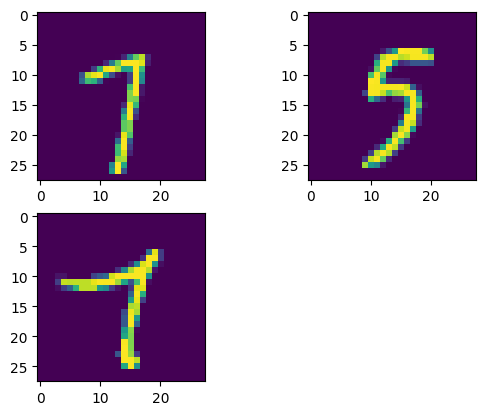

In [1]:
import numpy as np
import pandas as pd

import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras.models import Model
from keras.datasets import mnist


import matplotlib.pyplot as plt


(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train/255
x_test = x_test/255

img_width = x_train.shape[1]
img_height = x_train.shape[2]
num_channels = 1
x_train = x_train.reshape(x_train.shape[0], img_height, img_width, num_channels)
x_test = x_test.reshape(x_test.shape[0], img_height, img_width, num_channels)
input_shape = (img_height, img_width, num_channels)

plt.figure(1)
plt.subplot(221)
plt.imshow(x_train[42][:,:,0])

plt.subplot(222)
plt.imshow(x_train[420][:,:,0])

plt.subplot(223)
plt.imshow(x_train[4200][:,:,0])


In [2]:
import tensorflow as tf

### Encoder

In [3]:
import tensorflow.keras.backend as K

# 4 Conv2D, flatten and then dense

latent_dim = 2 # no. of latent dim parameters

input_img = Input(shape=input_shape, name='encoder_input')
x = Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = Conv2D(64, 3, padding='same', activation='relu', strides=(2,2))(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)

conv_shape = K.int_shape(x) # shape of conv to be provided to decoder

x = Flatten()(x) # flatten
x = Dense(32, activation='relu')(x)

#2 outputs, for latent mean and log variance (std. dev.)
#these are used to sample random variables in latent space to which inputs are mapped
z_mu = Dense(latent_dim, name='latent_mu')(x) # mean values of encoded input
z_sigma = Dense(latent_dim, name='latent_sigma')(x) # st.d de.v of encoded input


#REPARAMETERIZATION TRICK
# defining sampling function to sample from the distribution 
# reparameterise into shaoe of : mu + sigma squared x eps
# this allows gradient descent to allow for gradient estimation accurately
def sample_z(args):
    z_mu,z_sigma = args
    eps = K.random_normal(shape=(K.shape(z_mu)[0], K.int_shape(z_mu)[1]))
    return z_mu + K.exp(z_sigma / 2) *eps

#sample vector from the latent distribution
# z is the lambda custom layer we are adding for gradient descent calculations
# using mu and variance (sigma)
z = Lambda(sample_z, output_shape=(latent_dim,),name='z')([z_mu, z_sigma])

#z (lambda layer) will be the last layer in the encoder
# define and summarize encoder model.
encoder = Model(input_img, [z_mu, z_sigma, z], name='encoder')
print(encoder.summary())



Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 28, 28,    │        320 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 14, 14,    │     18,496 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 14, 14,    │     36,928 │ conv2d_1[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 14, 14,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 12544)     │          0 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │    401,440 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ latent_mu (Dense)   │ (None, 2)         │         66 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ latent_sigma        │ (None, 2)         │         66 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 2)         │          0 │ latent_mu[0][0],  │
│                     │                   │            │ latent_sigma[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 494,244 (1.89 MB)

 Trainable params: 494,244 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

None


### Decoder

In [4]:
# decoder takses the latent vector as input
decoder_input = Input(shape=(latent_dim, ), name='decoder_input')

#add dense layer with dimenstions that can be reshaped to original image shape
x = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation = 'relu')(decoder_input)

# reshape to the shape of last conv layer in encoder
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)

# upscale (conv2d transpose) back to original shape
# reverse the conv layers defined in the encoder
x = Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2,2))(x)

#add more conv2d if desired
#using sigmoid activation
x = Conv2DTranspose(num_channels, 3, padding='same', activation='sigmoid', name='decoder_output')(x)

decoder = Model(decoder_input, x, name='decoder')
decoder.summary()

#apply the decoder to the latent sample
z_decoded = decoder(z)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12544)          │        37,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output                  │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,385 (220.25 KB)

 Trainable params: 56,385 (220.25 KB)

 Non-trainable params: 0 (0.00 B)

### Loss

In [5]:
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Lambda, Reshape, Conv2DTranspose
from tensorflow.keras import Model
import tensorflow as tf
from tensorflow import keras

#custom loss
#VAE is trained using two loss functions reconstruction loss and KL divergence

class CustomLayer(keras.layers.Layer):
    
    def vae_loss(self, x, z_decoded, z_mu, z_sigma):
        # Flatten both x and z_decoded for reconstruction loss
        x_flat = Flatten()(x)
        z_decoded_flat = Flatten()(z_decoded)
        
        # Compute reconstruction loss using BinaryCrossentropy as we used sigmoid activation 
        reconstruction_loss = keras.losses.BinaryCrossentropy()(x_flat, z_decoded_flat)
        
        # Compute KL Divergence loss using z_mu and z_sigma
        kl_loss = -0.5 * K.sum(1 + z_sigma - K.square(z_mu) - K.exp(z_sigma), axis=-1)
        
        # Combine both losses
        return K.mean(reconstruction_loss + kl_loss)
    
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        z_mu = inputs[2]
        z_sigma = inputs[3]
        
        # Compute loss
        loss = self.vae_loss(x, z_decoded, z_mu, z_sigma)
        
        # Add the loss to the layer
        self.add_loss(loss)
        return x
        
# Pass z_mu and z_sigma to CustomLayer; apply to input image and decoded latent distribution
y = CustomLayer()([input_img, z_decoded, z_mu, z_sigma])
#y is basically the original image after encoding input img to mu, sigma, z and decoding sampled z values
# used as output for VAE

# Define and compile the VAE model
vae = Model(input_img, y, name='vae')
vae.compile(optimizer='adam')
vae.summary()


Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 28, 28,    │        320 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 14, 14,    │     18,496 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 14, 14,    │     36,928 │ conv2d_1[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 14, 14,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 12544)     │          0 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │    401,440 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ latent_mu (Dense)   │ (None, 2)         │         66 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ latent_sigma        │ (None, 2)         │         66 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 2)         │          0 │ latent_mu[0][0],  │
│                     │                   │            │ latent_sigma[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 28, 28, 1) │     56,385 │ z[0][0]           │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ custom_layer        │ (None, 28, 28, 1) │          0 │ encoder_input[0]… │
│ (CustomLayer)       │                   │            │ decoder[0][0],    │
│                     │                   │            │ latent_mu[0][0],  │
│                     │                   │            │ latent_sigma[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 550,629 (2.10 MB)

 Trainable params: 550,629 (2.10 MB)

 Non-trainable params: 0 (0.00 B)

### Training

In [6]:
# Training the model
vae.fit(x_train, None, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 110s 71ms/step - loss: 0.3045 - val_loss: 0.2626
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 106s 71ms/step - loss: 0.2640 - val_loss: 0.2625
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 106s 71ms/step - loss: 0.2633 - val_loss: 0.2626
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 107s 71ms/step - loss: 0.2637 - val_loss: 0.2624
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 107s 71ms/step - loss: 0.2633 - val_loss: 0.2623
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 107s 71ms/step - loss: 0.2629 - val_loss: 0.2623
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 108s 72ms/step - loss: 0.2638 - val_loss: 0.2622
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 108s 72ms/step - loss: 0.2631 - val_loss: 0.2623
Epoch 9/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 143s 73ms/step - loss: 0.2632 - val_loss: 0.2622
Epoch 10/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 110s 73ms/step - loss: 0.2636 - val_loss: 0.2623


### Analysis

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


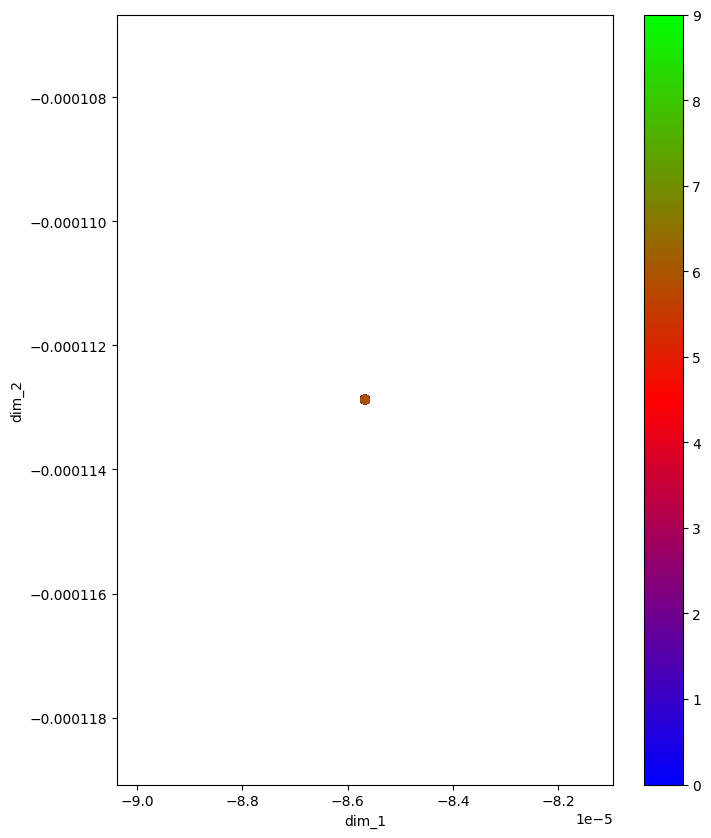

In [7]:
#visualise results
#inputs mapped to latent space
# we have encoded latent space dimension = 2
#extract z_mu -> first param in the result of the encoder prediction representation
mu, _, _ = encoder.predict(x_test)
plt.figure(figsize=(8,10))
plt.scatter(mu[:,0], mu[:,1], c=y_test, cmap='brg')
plt.xlabel('dim_1')
plt.ylabel('dim_2')
plt.colorbar()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


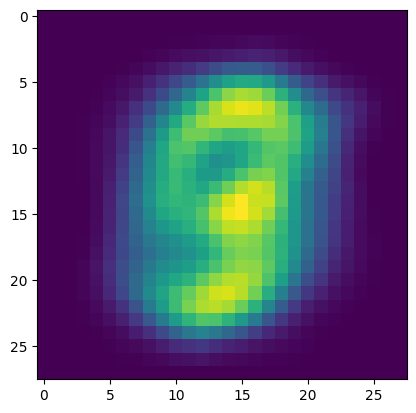

In [8]:
sample_vector = np.array([[1,3]])
decoded_example= decoder.predict(sample_vector)
decoded_example_reshaped = decoded_example.reshape(img_width, img_height)
plt.imshow(decoded_example_reshaped)